In [30]:
import pandas as pd
import numpy as np
import os as os
import acessos as ac
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import datetime
import imgkit

## QUERY

In [31]:

dt_query = "2020-12-01"

In [32]:
query = f"""

with base_aprovados as (
	select 
	dt_mes,
	sum(qtd_contas_total_acum) as qtd_contas_total_acum,
	sum(contas_novas) as contas_novas
	from platform_analytics_zone.monthly_kpis_pag_will 
	group by 1
)
, chats_agg as (
	select 
	dt_chat,
 	max(qtd_contas_total_acum) as qtd_contas_total_acum,
	max(contas_novas) as contas_novas,
  	max(is_holiday) as is_holiday,
	max(is_holiday_or_event) as is_holiday_or_event,
	max(is_eve) as is_eve,
	max(is_post) as is_post,
 	max(case when ds_holiday_or_event = 'Natal' then 1 else 0 end) as flag_natal,
	max(case when ds_holiday_or_event = 'Carnaval' and is_holiday = 1  then 1 else 0 end) as flag_carnaval,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) <= 5 then 1 else 0 end) as flag_5,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 6 and 10 then 1 else 0 end) as flag_6_10,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 11 and 15 then 1 else 0 end) as flag_11_15,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 16 and 20 then 1 else 0 end) as flag_16_20,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 21 and 25 then 1 else 0 end) as flag_21_26,
	max(case when cast(substring(cast(dt_date as varchar), 9, 2) as int) between 26 and 31 then 1 else 0 end) as flag_26_mais,
  	count(distinct id_issue) as chats
	FROM cx_curated_zone.cx_contact_rate c
 	left join base_aprovados a on (a.dt_mes = date_trunc('month', cast(c.dt_chat as date)))
  	left join customer_curated_zone.ca_dict_events e on (e.dt_date = cast(c.dt_chat as date))
	where dt_chat >= to_date('{dt_query}','yyyy-mm-dd')
	and dt_chat < date_add('day', -2, now())
	group by 1
)
, cartao_agg as (
	select 
	dia
	, SUM(ativos_dia) as ativos_dia 
	, SUM(spending_dia) as spending_dia 
	from platform_analytics_zone.daily_spending_pag_will
	where cast(dia as date) >= to_date('{dt_query}','yyyy-mm-dd')
	group by 1
	order by 1
)
select
c.dt_chat
, chats
, qtd_contas_total_acum
, contas_novas
, ativos_dia
, is_holiday
, is_eve
, is_post
, flag_natal
, flag_carnaval
, spending_dia
from chats_agg c
left join cartao_agg ct on (c.dt_chat = cast(ct.dia as date))
order by dt_chat asc


"""

In [33]:
df_1 = ac.df_athena('flavia-costa', query)

In [34]:
#variavel resposta - proximos 30 dias
df_1['spending_dia_rol'] = df_1.spending_dia.shift(5).rolling(window = 25).mean()


In [35]:
df_1['chats_lag1'] = df_1.chats.shift(1)

In [36]:
df_1.columns

Index(['dt_chat', 'chats', 'qtd_contas_total_acum', 'contas_novas',
       'ativos_dia', 'is_holiday', 'is_eve', 'is_post', 'flag_natal',
       'flag_carnaval', 'spending_dia', 'spending_dia_rol', 'chats_lag1'],
      dtype='object')

In [37]:
df_1.head()

,dt_chat,chats,qtd_contas_total_acum,contas_novas,ativos_dia,is_holiday,is_eve,is_post,flag_natal,flag_carnaval,spending_dia,spending_dia_rol,chats_lag1
0,2020-12-01,8538,1462427,48192,102718,0,0,1,0,0,15296292,NaN,NaN
1,2020-12-02,7691,1462427,48192,101991,0,0,1,0,0,14710532,NaN,8538.0
2,2020-12-03,7442,1462427,48192,102247,0,0,0,0,0,14817874,NaN,7691.0
3,2020-12-04,9708,1462427,48192,117320,0,0,0,0,0,18033912,NaN,7442.0
4,2020-12-05,4518,1462427,48192,124574,0,0,0,0,0,18466489,NaN,9708.0


## Join df final

In [38]:
df_1['dt_chat'] = pd.to_datetime(df_1['dt_chat'])

## Análise de algumas séries

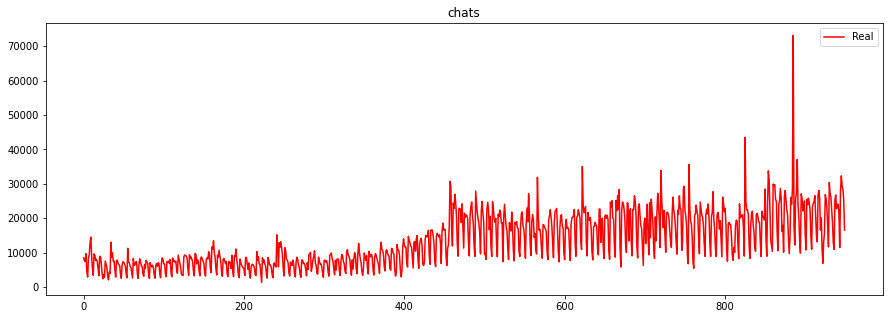

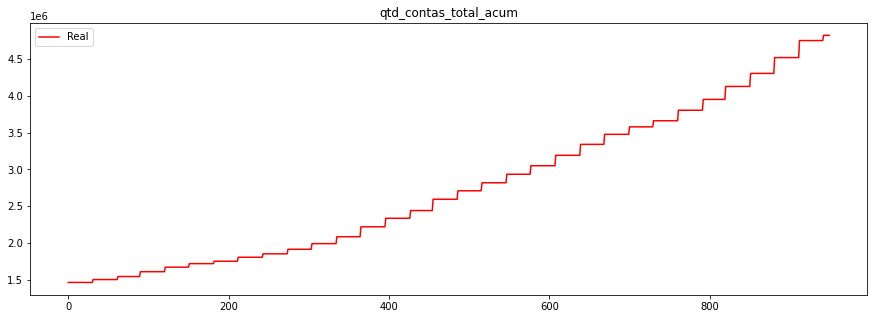

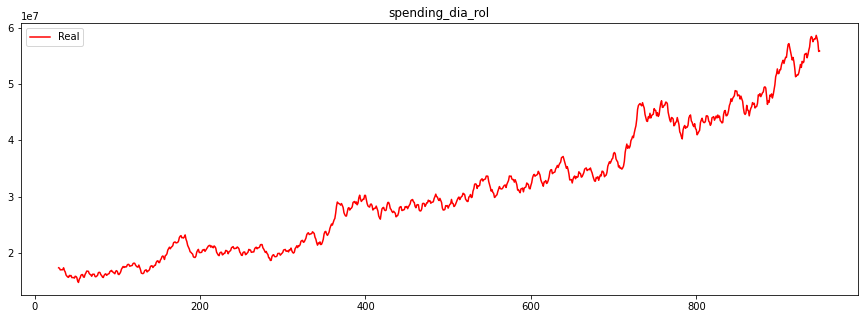

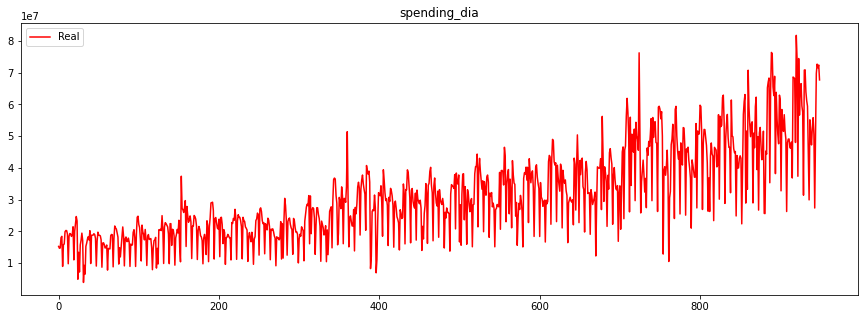

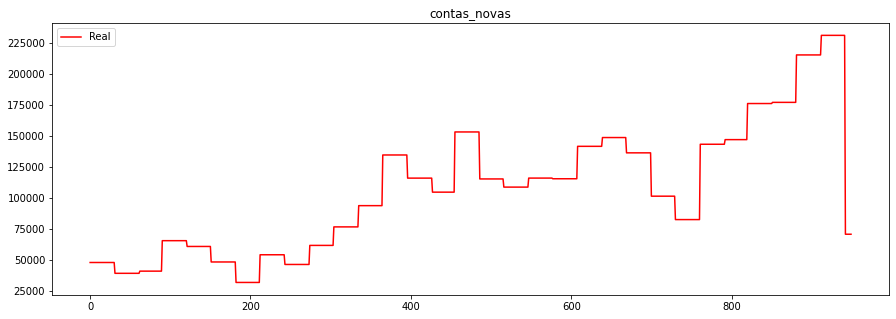

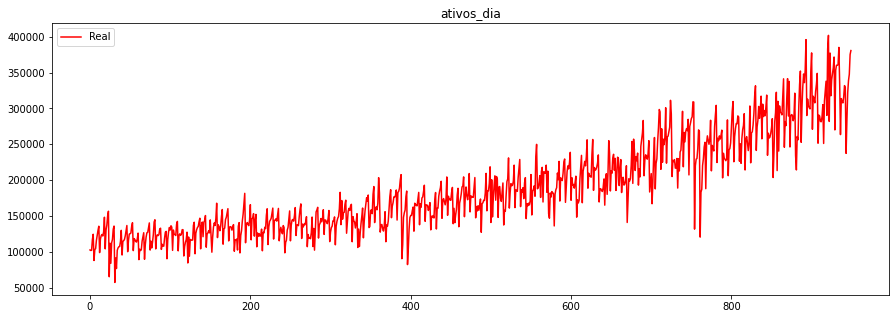

In [39]:

 graficos = ['chats', 'qtd_contas_total_acum', 'spending_dia_rol', 'spending_dia', 'contas_novas', 'ativos_dia']
#'p_clientes_ocorr_8a10'
for i in graficos:
  plt.figure(figsize=(15,5))
  plt.plot(df_1[i], color = 'red', label = 'Real')
  plt.legend()
  plt.title(i)

In [40]:
df_1.corr(method='pearson').to_csv('correl.csv')

## Logs

In [41]:
drop_log = ['dt_chat','is_holiday','is_eve','is_post','flag_natal','flag_carnaval']
variaveis_log = df_1.drop('dt_chat', axis = 1).columns

for i in variaveis_log:
  if len(df_1[i].unique()) <= 2:
    if (df_1[i] == 0).any():
      df_1['ln_' + i] = df_1[i]
  elif pd.api.types.is_numeric_dtype(df_1[i]):
    df_1['ln_' + i] = np.log(df_1[i])

In [42]:
print(len(df_1))
df = df_1.query('spending_dia_rol > 0')
print(len(df))

950
921


In [43]:
df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
df['mes'] = df['dt_chat'].map(lambda x: x.strftime('%m'))
df['dia_semana'] = df['dt_chat'].map(lambda x: x.strftime('%A'))

/tmp/ipykernel_2069888/23436780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
/tmp/ipykernel_2069888/23436780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
/tmp/ipykernel_2069888/23436780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt


## Transformações para modelagem

In [44]:
df['chats_cliente']  = df['chats'] / df['qtd_contas_total_acum']
df['spending_rol_cliente']  = df['spending_dia_rol'] / df['qtd_contas_total_acum']

/tmp/ipykernel_2069888/4121393923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['chats_cliente']  = df['chats'] / df['qtd_contas_total_acum']
/tmp/ipykernel_2069888/4121393923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spending_rol_cliente']  = df['spending_dia_rol'] / df['qtd_contas_total_acum']


In [45]:
df['spending_rol_ativos']  = df['spending_dia_rol'] / df['ativos_dia']

/tmp/ipykernel_2069888/2456795867.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spending_rol_ativos']  = df['spending_dia_rol'] / df['ativos_dia']


In [46]:
df['ativos_cliente']  = df['ativos_dia'] / df['qtd_contas_total_acum']

/tmp/ipykernel_2069888/2793834979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ativos_cliente']  = df['ativos_dia'] / df['qtd_contas_total_acum']


In [47]:
df['spending_rol_l1'] = df.spending_rol_cliente.shift(1)

/tmp/ipykernel_2069888/745491375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spending_rol_l1'] = df.spending_rol_cliente.shift(1)


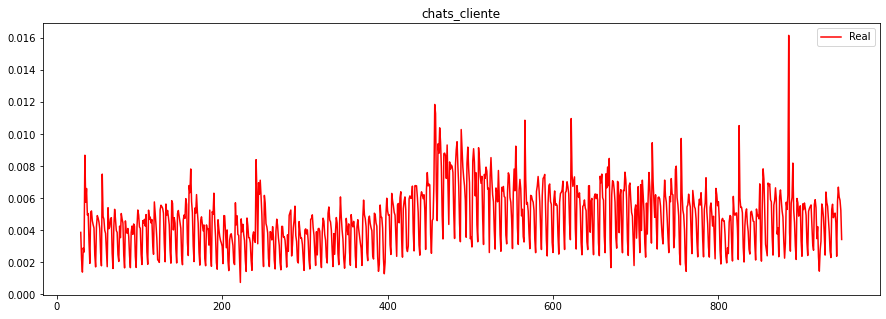

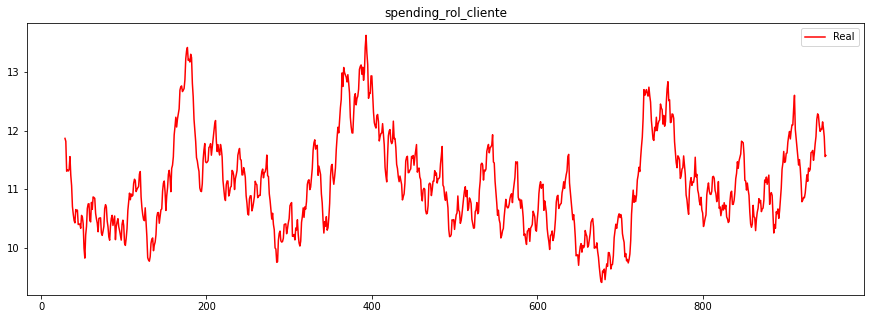

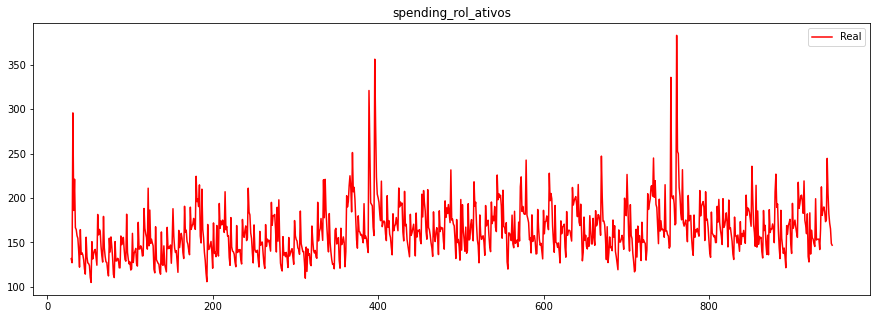

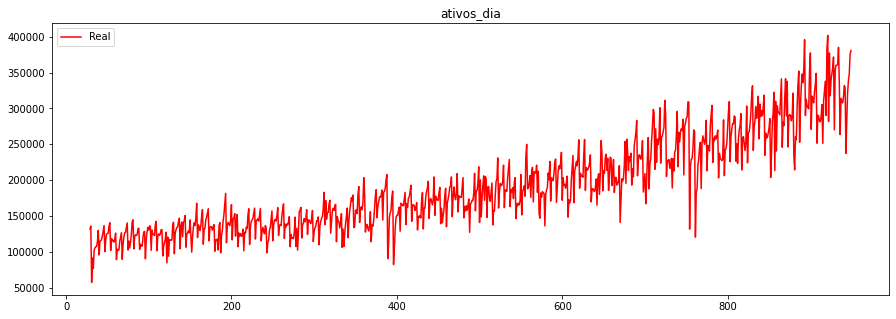

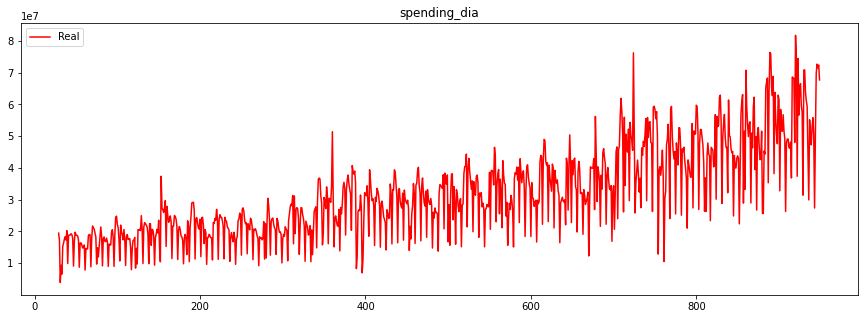

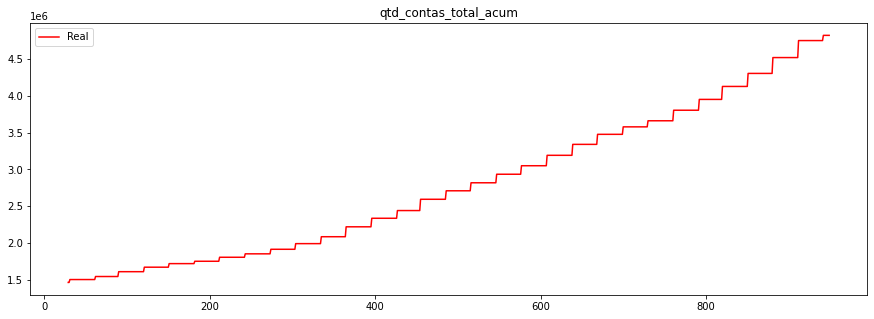

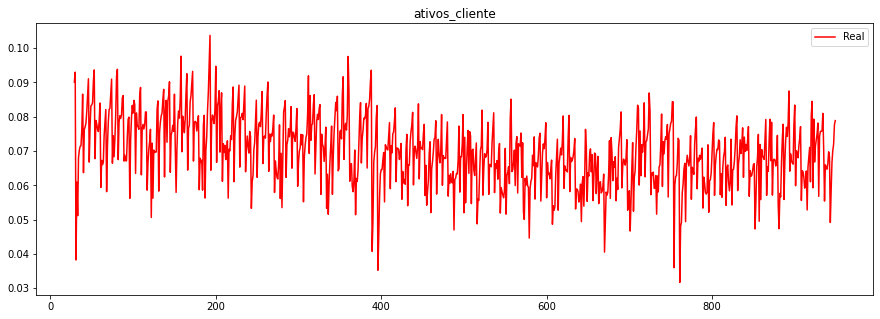

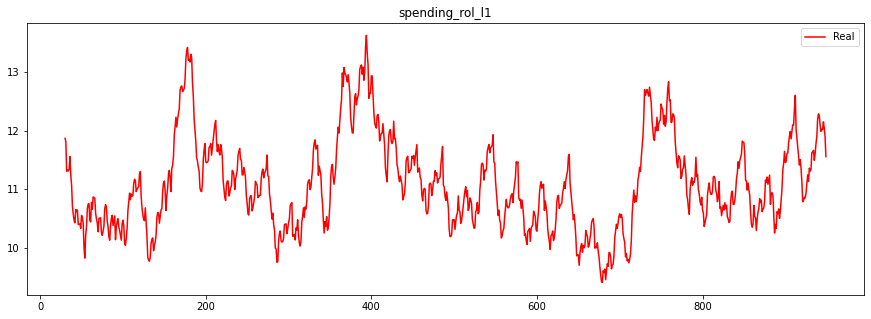

In [48]:
graficos = ['chats_cliente', 'spending_rol_cliente', 'spending_rol_ativos', 'ativos_dia', 'spending_dia', 'qtd_contas_total_acum', 'ativos_cliente', 'spending_rol_l1']

for i in graficos:
  plt.figure(figsize=(15,5))
  plt.plot(df[i], color = 'red', label = 'Real')
  plt.legend()
  plt.title(i)

In [49]:
df[graficos].corr(method='pearson')

,chats_cliente,spending_rol_cliente,spending_rol_ativos,ativos_dia,spending_dia,qtd_contas_total_acum,ativos_cliente,spending_rol_l1
chats_cliente,1.000000,-0.038649,-0.107389,0.236558,0.445230,0.207033,0.012829,-0.051246
spending_rol_cliente,-0.038649,1.000000,0.440010,-0.015397,0.009021,-0.005475,-0.034489,0.973751
spending_rol_ativos,-0.107389,0.440010,1.000000,-0.086606,-0.168133,0.258573,-0.874474,0.448449
ativos_dia,0.236558,-0.015397,-0.086606,1.000000,0.925136,0.916301,0.038570,-0.018497
spending_dia,0.445230,0.009021,-0.168133,0.925136,1.000000,0.802073,0.131241,0.005961
qtd_contas_total_acum,0.207033,-0.005475,0.258573,0.916301,0.802073,1.000000,-0.343258,-0.004059
ativos_cliente,0.012829,-0.034489,-0.874474,0.038570,0.131241,-0.343258,1.000000,-0.044829
spending_rol_l1,-0.051246,0.973751,0.448449,-0.018497,0.005961,-0.004059,-0.044829,1.000000


In [50]:
df['ln_spending_rol_cliente'] = np.log(df.spending_rol_cliente)
df['ln_chats_cliente'] = np.log(df.chats_cliente)
df['ln_ativos_cliente'] = np.log(df.ativos_cliente)
df['ln_spending_rol_l1_cliente'] = np.log(df.spending_rol_l1)

/tmp/ipykernel_2069888/915161747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ln_spending_rol_cliente'] = np.log(df.spending_rol_cliente)
/tmp/ipykernel_2069888/915161747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ln_chats_cliente'] = np.log(df.chats_cliente)
/tmp/ipykernel_2069888/915161747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [51]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_ativos_dia + 
ln_chats_cliente

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.656
Model:                                 OLS   Adj. R-squared:                  0.633
Method:                      Least Squares   F-statistic:                     28.88
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):          1.12e-161
Time:                             20:02:38   Log-Likelihood:                 1641.1
No. Observations:                      921   AIC:                            -3166.
Df Residuals:                          863   BIC:                            -2886.
Df Model:                               57                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      3.9287      0.291     13.481      0.000       3.357       4.501
C(ano)[T.2021]                 0.1564      0.032      4.916      0.000       0.094       0.219
C(ano)[T.2022]                 0.2010      0.035      5.759      0.000       0.132       0.269
C(ano)[T.2023]                 0.2837      0.041      6.941      0.000       0.203       0.364
C(dia)[T.02]                  -0.0026      0.011     -0.245      0.807      -0.024       0.019
C(dia)[T.03]                  -0.0046      0.011     -0.425      0.671      -0.026       0.017
C(dia)[T.04]                   0.0075      0.011      0.671      0.502      -0.014       0.030
C(dia)[T.05]                   0.0036      0.011      0.318      0.751      -0.019       0.026
C(dia)[T.06]                  -0.0091      0.011     -0.811      0.418      -0.031       0.013
C(dia)[T.07]                  -0.0167      0.011     -1.504      0.133      -0.039       0.005
C(dia)[T.08]                  -0.0281      0.011     -2.500      0.013      -0.050      -0.006
C(dia)[T.09]                  -0.0262      0.012     -2.202      0.028      -0.049      -0.003
C(dia)[T.10]                  -0.0239      0.012     -1.964      0.050      -0.048    -1.2e-05
C(dia)[T.11]                  -0.0273      0.012     -2.277      0.023      -0.051      -0.004
C(dia)[T.12]                  -0.0262      0.012     -2.179      0.030      -0.050      -0.003
C(dia)[T.13]                  -0.0311      0.012     -2.644      0.008      -0.054      -0.008
C(dia)[T.14]                  -0.0188      0.012     -1.569      0.117      -0.042       0.005
C(dia)[T.15]                  -0.0046      0.012     -0.387      0.699      -0.028       0.019
C(dia)[T.16]                  -0.0016      0.012     -0.135      0.893      -0.025       0.021
C(dia)[T.17]                   0.0009      0.012      0.075      0.940      -0.022       0.024
C(dia)[T.18]               -6.251e-05      0.012     -0.005      0.996      -0.023       0.023
C(dia)[T.19]                   0.0157      0.012      1.268      0.205      -0.009       0.040
C(dia)[T.20]                   0.0174      0.012      1.391      0.164      -0.007       0.042
C(dia)[T.21]                   0.0162      0.012      1.321      0.187      -0.008       0.040
C(dia)[T.22]                   0.0110      0.012      0.913      0.361      -0.013       0.035
C(dia)[T.23]                   0.0102      0.012      0.845      0.398      -0.013       0.034
C(dia)[T.24]                   0.0168      0.012      1.414      0.158      -0.007       0.040
C(dia)[T.25]                   0.0262      0.012      2.234      0.026       0.003       0.049
C(dia)[T.26]                   0.0283      0.012      2.446      0.015       0.006 

In [52]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_spending_dia + 
ln_chats_cliente

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.642
Model:                                 OLS   Adj. R-squared:                  0.619
Method:                      Least Squares   F-statistic:                     27.19
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):          1.40e-154
Time:                             20:02:38   Log-Likelihood:                 1623.1
No. Observations:                      921   AIC:                            -3130.
Df Residuals:                          863   BIC:                            -2850.
Df Model:                               57                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.9940      0.262      7.605      0.000       1.479       2.509
C(ano)[T.2021]                 0.1228      0.033      3.770      0.000       0.059       0.187
C(ano)[T.2022]                 0.1056      0.035      3.028      0.003       0.037       0.174
C(ano)[T.2023]                 0.1116      0.038      2.912      0.004       0.036       0.187
C(dia)[T.02]                   0.0018      0.011      0.168      0.866      -0.020       0.023
C(dia)[T.03]                  -0.0017      0.011     -0.157      0.875      -0.023       0.020
C(dia)[T.04]                  -0.0085      0.012     -0.712      0.477      -0.032       0.015
C(dia)[T.05]                  -0.0152      0.012     -1.278      0.202      -0.039       0.008
C(dia)[T.06]                  -0.0274      0.012     -2.311      0.021      -0.051      -0.004
C(dia)[T.07]                  -0.0358      0.012     -3.051      0.002      -0.059      -0.013
C(dia)[T.08]                  -0.0502      0.012     -4.233      0.000      -0.074      -0.027
C(dia)[T.09]                  -0.0575      0.013     -4.466      0.000      -0.083      -0.032
C(dia)[T.10]                  -0.0605      0.013     -4.676      0.000      -0.086      -0.035
C(dia)[T.11]                  -0.0609      0.012     -4.906      0.000      -0.085      -0.037
C(dia)[T.12]                  -0.0609      0.012     -5.036      0.000      -0.085      -0.037
C(dia)[T.13]                  -0.0601      0.012     -5.085      0.000      -0.083      -0.037
C(dia)[T.14]                  -0.0516      0.012     -4.267      0.000      -0.075      -0.028
C(dia)[T.15]                  -0.0391      0.012     -3.258      0.001      -0.063      -0.016
C(dia)[T.16]                  -0.0307      0.012     -2.628      0.009      -0.054      -0.008
C(dia)[T.17]                  -0.0251      0.012     -2.179      0.030      -0.048      -0.002
C(dia)[T.18]                  -0.0236      0.011     -2.061      0.040      -0.046      -0.001
C(dia)[T.19]                  -0.0219      0.012     -1.779      0.076      -0.046       0.002
C(dia)[T.20]                  -0.0227      0.012     -1.851      0.064      -0.047       0.001
C(dia)[T.21]                  -0.0222      0.012     -1.867      0.062      -0.046       0.001
C(dia)[T.22]                  -0.0228      0.012     -1.943      0.052      -0.046       0.000
C(dia)[T.23]                  -0.0227      0.012     -1.956      0.051      -0.045    7.97e-05
C(dia)[T.24]                  -0.0099      0.012     -0.857      0.392      -0.033       0.013
C(dia)[T.25]                   0.0001      0.012      0.012      0.990      -0.023       0.023
C(dia)[T.26]                   0.0043      0.011      0.378      0.705      -0.018 

In [53]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_qtd_contas_total_acum + 
ln_chats_cliente

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.736
Model:                                 OLS   Adj. R-squared:                  0.719
Method:                      Least Squares   F-statistic:                     42.25
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):          5.23e-210
Time:                             20:02:38   Log-Likelihood:                 1763.3
No. Observations:                      921   AIC:                            -3411.
Df Residuals:                          863   BIC:                            -3131.
Df Model:                               57                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.6625      0.994     19.779      0.000      17.711      21.614
C(ano)[T.2021]                 0.6448      0.040     15.997      0.000       0.566       0.724
C(ano)[T.2022]                 1.2702      0.071     17.797      0.000       1.130       1.410
C(ano)[T.2023]                 1.8677      0.103     18.174      0.000       1.666       2.069
C(dia)[T.02]                   0.0018      0.009      0.192      0.847      -0.017       0.020
C(dia)[T.03]                  -0.0018      0.009     -0.192      0.848      -0.020       0.017
C(dia)[T.04]                  -0.0072      0.010     -0.748      0.455      -0.026       0.012
C(dia)[T.05]                  -0.0133      0.010     -1.386      0.166      -0.032       0.006
C(dia)[T.06]                  -0.0251      0.010     -2.620      0.009      -0.044      -0.006
C(dia)[T.07]                  -0.0333      0.009     -3.513      0.000      -0.052      -0.015
C(dia)[T.08]                  -0.0464      0.009     -4.899      0.000      -0.065      -0.028
C(dia)[T.09]                  -0.0536      0.010     -5.528      0.000      -0.073      -0.035
C(dia)[T.10]                  -0.0561      0.010     -5.800      0.000      -0.075      -0.037
C(dia)[T.11]                  -0.0559      0.010     -5.800      0.000      -0.075      -0.037
C(dia)[T.12]                  -0.0569      0.010     -5.970      0.000      -0.076      -0.038
C(dia)[T.13]                  -0.0563      0.010     -5.872      0.000      -0.075      -0.038
C(dia)[T.14]                  -0.0481      0.010     -4.997      0.000      -0.067      -0.029
C(dia)[T.15]                  -0.0356      0.009     -3.753      0.000      -0.054      -0.017
C(dia)[T.16]                  -0.0277      0.010     -2.898      0.004      -0.046      -0.009
C(dia)[T.17]                  -0.0224      0.010     -2.337      0.020      -0.041      -0.004
C(dia)[T.18]                  -0.0215      0.010     -2.244      0.025      -0.040      -0.003
C(dia)[T.19]                  -0.0196      0.010     -2.019      0.044      -0.039      -0.001
C(dia)[T.20]                  -0.0195      0.010     -2.031      0.043      -0.038      -0.001
C(dia)[T.21]                  -0.0191      0.009     -2.009      0.045      -0.038      -0.000
C(dia)[T.22]                  -0.0199      0.010     -2.072      0.039      -0.039      -0.001
C(dia)[T.23]                  -0.0196      0.010     -2.042      0.041      -0.038      -0.001
C(dia)[T.24]                  -0.0077      0.010     -0.794      0.428      -0.027       0.011
C(dia)[T.25]                   0.0013      0.010      0.134      0.893      -0.018       0.020
C(dia)[T.26]                   0.0055      0.010      0.569      0.569      -0.013 

In [54]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_qtd_contas_total_acum +
ln_ativos_cliente + 
ln_chats_cliente 

"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.737
Model:                                 OLS   Adj. R-squared:                  0.720
Method:                      Least Squares   F-statistic:                     41.70
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):          6.61e-210
Time:                             20:02:39   Log-Likelihood:                 1765.1
No. Observations:                      921   AIC:                            -3412.
Df Residuals:                          862   BIC:                            -3127.
Df Model:                               58                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.5947      0.993     19.724      0.000      17.645      21.545
C(ano)[T.2021]                 0.6366      0.041     15.718      0.000       0.557       0.716
C(ano)[T.2022]                 1.2577      0.072     17.566      0.000       1.117       1.398
C(ano)[T.2023]                 1.8564      0.103     18.057      0.000       1.655       2.058
C(dia)[T.02]                   0.0007      0.009      0.074      0.941      -0.018       0.019
C(dia)[T.03]                  -0.0027      0.009     -0.281      0.779      -0.021       0.016
C(dia)[T.04]                  -0.0037      0.010     -0.373      0.709      -0.023       0.016
C(dia)[T.05]                  -0.0090      0.010     -0.915      0.360      -0.028       0.010
C(dia)[T.06]                  -0.0210      0.010     -2.132      0.033      -0.040      -0.002
C(dia)[T.07]                  -0.0289      0.010     -2.965      0.003      -0.048      -0.010
C(dia)[T.08]                  -0.0413      0.010     -4.191      0.000      -0.061      -0.022
C(dia)[T.09]                  -0.0464      0.010     -4.432      0.000      -0.067      -0.026
C(dia)[T.10]                  -0.0474      0.011     -4.410      0.000      -0.068      -0.026
C(dia)[T.11]                  -0.0478      0.011     -4.524      0.000      -0.069      -0.027
C(dia)[T.12]                  -0.0484      0.011     -4.567      0.000      -0.069      -0.028
C(dia)[T.13]                  -0.0492      0.010     -4.758      0.000      -0.070      -0.029
C(dia)[T.14]                  -0.0400      0.011     -3.788      0.000      -0.061      -0.019
C(dia)[T.15]                  -0.0271      0.011     -2.571      0.010      -0.048      -0.006
C(dia)[T.16]                  -0.0204      0.010     -1.977      0.048      -0.041      -0.000
C(dia)[T.17]                  -0.0158      0.010     -1.551      0.121      -0.036       0.004
C(dia)[T.18]                  -0.0155      0.010     -1.535      0.125      -0.035       0.004
C(dia)[T.19]                  -0.0102      0.011     -0.934      0.351      -0.032       0.011
C(dia)[T.20]                  -0.0095      0.011     -0.862      0.389      -0.031       0.012
C(dia)[T.21]                  -0.0094      0.011     -0.865      0.387      -0.031       0.012
C(dia)[T.22]                  -0.0113      0.011     -1.057      0.291      -0.032       0.010
C(dia)[T.23]                  -0.0112      0.011     -1.051      0.293      -0.032       0.010
C(dia)[T.24]                  -0.0008      0.010     -0.077      0.938      -0.021       0.020
C(dia)[T.25]                   0.0080      0.010      0.775      0.439      -0.012       0.028
C(dia)[T.26]                   0.0117      0.010      1.150      0.250      -0.008 

In [55]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post+
ln_qtd_contas_total_acum +
ln_ativos_cliente + 
ln_chats_cliente +
ln_spending_rol_l1_cliente
"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.989
Model:                                 OLS   Adj. R-squared:                  0.989
Method:                      Least Squares   F-statistic:                     1348.
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                             20:02:39   Log-Likelihood:                 3235.8
No. Observations:                      920   AIC:                            -6352.
Df Residuals:                          860   BIC:                            -6062.
Df Model:                               59                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2011      0.243      0.829      0.407      -0.275       0.677
C(ano)[T.2021]                 0.0223      0.011      2.072      0.039       0.001       0.043
C(ano)[T.2022]                 0.0297      0.018      1.677      0.094      -0.005       0.064
C(ano)[T.2023]                 0.0371      0.025      1.486      0.138      -0.012       0.086
C(dia)[T.02]                   0.0353      0.002     18.416      0.000       0.032       0.039
C(dia)[T.03]                   0.0294      0.002     15.283      0.000       0.026       0.033
C(dia)[T.04]                   0.0258      0.002     12.926      0.000       0.022       0.030
C(dia)[T.05]                   0.0247      0.002     12.329      0.000       0.021       0.029
C(dia)[T.06]                   0.0189      0.002      9.455      0.000       0.015       0.023
C(dia)[T.07]                   0.0211      0.002     10.519      0.000       0.017       0.025
C(dia)[T.08]                   0.0184      0.002      9.023      0.000       0.014       0.022
C(dia)[T.09]                   0.0243      0.002     11.185      0.000       0.020       0.029
C(dia)[T.10]                   0.0266      0.002     11.904      0.000       0.022       0.031
C(dia)[T.11]                   0.0293      0.002     13.305      0.000       0.025       0.034
C(dia)[T.12]                   0.0280      0.002     12.712      0.000       0.024       0.032
C(dia)[T.13]                   0.0305      0.002     14.101      0.000       0.026       0.035
C(dia)[T.14]                   0.0371      0.002     16.872      0.000       0.033       0.041
C(dia)[T.15]                   0.0417      0.002     19.083      0.000       0.037       0.046
C(dia)[T.16]                   0.0386      0.002     18.157      0.000       0.034       0.043
C(dia)[T.17]                   0.0364      0.002     17.348      0.000       0.032       0.040
C(dia)[T.18]                   0.0312      0.002     15.072      0.000       0.027       0.035
C(dia)[T.19]                   0.0307      0.002     13.795      0.000       0.026       0.035
C(dia)[T.20]                   0.0297      0.002     13.222      0.000       0.025       0.034
C(dia)[T.21]                   0.0298      0.002     13.519      0.000       0.026       0.034
C(dia)[T.22]                   0.0294      0.002     13.523      0.000       0.025       0.034
C(dia)[T.23]                   0.0301      0.002     13.898      0.000       0.026       0.034
C(dia)[T.24]                   0.0424      0.002     19.935      0.000       0.038       0.047
C(dia)[T.25]                   0.0395      0.002     18.854      0.000       0.035       0.044
C(dia)[T.26]                   0.0364      0.002     17.659      0.000       0.032 

In [56]:
df['Indice'] = list(range(len(df.index)))
df['Indice'] = df['Indice'] + 1

/tmp/ipykernel_2069888/3494948153.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Indice'] = list(range(len(df.index)))
/tmp/ipykernel_2069888/3494948153.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Indice'] = df['Indice'] + 1


In [57]:
formula_text = """
ln_spending_rol_cliente ~
+ C(ano) +C(dia) +C(mes) +C(dia_semana) +is_holiday +is_eve +flag_natal +flag_carnaval+ is_post +
Indice + 
ln_qtd_contas_total_acum +
ln_ativos_cliente + 
ln_chats_cliente 
"""
model = ols(formula = formula_text, data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ln_spending_rol_cliente   R-squared:                       0.737
Model:                                 OLS   Adj. R-squared:                  0.720
Method:                      Least Squares   F-statistic:                     41.70
Date:                     Mon, 10 Jul 2023   Prob (F-statistic):          6.61e-210
Time:                             20:02:39   Log-Likelihood:                 1765.1
No. Observations:                      921   AIC:                            -3412.
Df Residuals:                          862   BIC:                            -3127.
Df Model:                               58                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     19.1238      0.971     19.693      0.000      17.218      21.030
C(ano)[T.2021]                 1.1114      0.055     20.374      0.000       1.004       1.218
C(ano)[T.2022]                 2.2074      0.110     19.990      0.000       1.991       2.424
C(ano)[T.2023]                 3.2809      0.166     19.800      0.000       2.956       3.606
C(dia)[T.02]                   0.0020      0.009      0.212      0.832      -0.017       0.020
C(dia)[T.03]               -5.547e-05      0.009     -0.006      0.995      -0.019       0.019
C(dia)[T.04]                   0.0002      0.010      0.024      0.981      -0.019       0.020
C(dia)[T.05]                  -0.0038      0.010     -0.389      0.698      -0.023       0.016
C(dia)[T.06]                  -0.0144      0.010     -1.472      0.141      -0.034       0.005
C(dia)[T.07]                  -0.0211      0.010     -2.168      0.030      -0.040      -0.002
C(dia)[T.08]                  -0.0322      0.010     -3.270      0.001      -0.052      -0.013
C(dia)[T.09]                  -0.0360      0.010     -3.442      0.001      -0.056      -0.015
C(dia)[T.10]                  -0.0357      0.011     -3.324      0.001      -0.057      -0.015
C(dia)[T.11]                  -0.0348      0.011     -3.292      0.001      -0.056      -0.014
C(dia)[T.12]                  -0.0341      0.011     -3.216      0.001      -0.055      -0.013
C(dia)[T.13]                  -0.0336      0.010     -3.245      0.001      -0.054      -0.013
C(dia)[T.14]                  -0.0231      0.011     -2.186      0.029      -0.044      -0.002
C(dia)[T.15]                  -0.0089      0.011     -0.844      0.399      -0.030       0.012
C(dia)[T.16]                  -0.0009      0.010     -0.085      0.932      -0.021       0.019
C(dia)[T.17]                   0.0050      0.010      0.485      0.628      -0.015       0.025
C(dia)[T.18]                   0.0066      0.010      0.649      0.517      -0.013       0.026
C(dia)[T.19]                   0.0132      0.011      1.207      0.228      -0.008       0.035
C(dia)[T.20]                   0.0152      0.011      1.375      0.169      -0.006       0.037
C(dia)[T.21]                   0.0166      0.011      1.529      0.127      -0.005       0.038
C(dia)[T.22]                   0.0160      0.011      1.499      0.134      -0.005       0.037
C(dia)[T.23]                   0.0175      0.011      1.633      0.103      -0.004       0.038
C(dia)[T.24]                   0.0291      0.010      2.774      0.006       0.009       0.050
C(dia)[T.25]                   0.0392      0.010      3.781      0.000       0.019       0.060
C(dia)[T.26]                   0.0442      0.010      4.316      0.000       0.024 